In [6]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv('../data/processed/booking_data.csv')

# Inspección inicial
df.head()

C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_11340\1013993835.py:4: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/booking_data.csv')


,hotel,cancelado,regimen,canal_distribucion,tipo_cliente,cliente_recurrente,reservas_previas_no_canceladas,adultos,ninos,hombres,...,ubicación,campaña_asignada,lanzamiento_inicio,lanzamiento_fin,fecha_inicio,fecha_fin,tiene_campaña,review_text,review_sentiment,año
0,gran hotel bali,0,bb,direct,jóvenes,0,0,1,0,1,...,benidorm,NaN,NaN,NaN,NaN,NaN,0,personal amable zona agradable habitacion ampl...,positive,2022
1,gran hotel bali,0,bb,corporate,jóvenes,0,0,1,0,1,...,benidorm,gran hotel bali campaña 2023 - 2 verano,2023-05-02,2023-05-30,2023-06-28,2023-07-25,1,i spent five nights and six days at this estab...,positive,2023
2,gran hotel bali,0,bb,ta/to,tercera edad,0,0,2,0,1,...,benidorm,gran hotel bali campaña 2020 - 1 semana santa,2020-03-08,2020-03-18,2020-03-28,2020-04-14,1,this was our 2nd time staying at this hotel we...,positive,2020
3,eurostars hotel de la reconquista,0,bb,ta/to,pareja,0,0,2,0,1,...,asturias,NaN,NaN,NaN,NaN,NaN,0,we booked a standard room six months before wi...,negative,2021
4,parador de cádiz,0,bb,direct,pareja,0,0,2,0,1,...,cádiz,NaN,NaN,NaN,NaN,NaN,0,the savoy is an excellent hotel on ocean drive...,positive,2024


In [9]:
df['fecha_inicio'] = pd.to_datetime(df['fecha_inicio'], errors='coerce')
df['semana'] = df['fecha_inicio'].dt.isocalendar().week
df['mes'] = df['fecha_inicio'].dt.month
df['año'] = df['fecha_inicio'].dt.year

## 📊 Enfoque 1: Modelo de Diferencia en Diferencias (DiD)
Este modelo compara la evolución de las reservas entre períodos con y sin campaña.

1. Definir grupos:
- Grupo Tratamiento: Períodos con campaña activa.
- Grupo Control: Períodos sin campaña activa.
2. Modelo de Diferencia en Diferencias (DiD) por Hotel



In [26]:
reservas_periodo = df.groupby(['hotel', 'año', 'mes', 'tiene_campaña']).size().reset_index(name='reservas')



In [ ]:
!pip install statsmodels

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Modelo de regresión
model = ols('reservas ~ C(año) + C(mes) + C(tiene_campaña)', data=reservas_periodo).fit()

# Resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               reservas   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1.296
Date:                Fri, 06 Jun 2025   Prob (F-statistic):              0.267
Time:                        10:12:25   Log-Likelihood:                -365.76
No. Observations:                  46   AIC:                             757.5
Df Residuals:                      33   BIC:                             781.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1016.6083    488.586  

📈 Paso 3: Modelos de Series Temporales (ARIMA/SARIMA)
Estos modelos permiten capturar patrones temporales y prever el impacto de las campañas.

Preparar la serie temporal:

In [29]:
reservas_ts = df.groupby(['hotel', 'fecha_inicio']).size().unstack(fill_value=0)
# Transponer para que las fechas sean el índice
reservas_ts = reservas_ts.T
reservas_ts.index = pd.to_datetime(reservas_ts.index)
reservas_ts = reservas_ts.resample('D').sum()  # Resampleo diario

Aquí, .size() cuenta el número de reservas por día.
2. Comprobar estacionariedad:

In [32]:
from statsmodels.tsa.stattools import adfuller

# Prueba de ADF para todos los hoteles
for hotel in reservas_ts.columns:
    result = adfuller(reservas_ts[hotel])
    print(f'Hotel: {hotel}')
    print(f'  Estadístico ADF: {result[0]}')
    print(f'  p-valor: {result[1]}')
    print('-' * 40)

Hotel: eurostars hotel de la reconquista
  Estadístico ADF: -9.39759114906484
  p-valor: 6.312950570975995e-16
----------------------------------------
Hotel: gran hotel bali
  Estadístico ADF: -15.906548161056314
  p-valor: 8.214676040497018e-29
----------------------------------------
Hotel: hotel arts barcelona
  Estadístico ADF: -42.3511609498551
  p-valor: 0.0
----------------------------------------
Hotel: mandarin oriental ritz
  Estadístico ADF: -19.845948045065388
  p-valor: 0.0
----------------------------------------
Hotel: parador de cádiz
  Estadístico ADF: -9.13250215815723
  p-valor: 2.9957137404823747e-15
----------------------------------------


Si el p-valor es alto, es necesario diferenciar la serie para hacerla estacionaria.

3.Ajustar el modelo ARIMA/SARIMA:

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ajustar un modelo SARIMA para cada hotel y guardar los resultados en un diccionario
sarima_results = {}

for hotel in reservas_ts.columns:
    model = SARIMAX(reservas_ts[hotel], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    results = model.fit(disp=False)
    sarima_results[hotel] = results
    print(f"Resumen para {hotel}:")
    print(results.summary())
    print("="*80)


Resumen para eurostars hotel de la reconquista:
                                       SARIMAX Results                                       
Dep. Variable:     eurostars hotel de la reconquista   No. Observations:                 2083
Model:                 SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -9209.095
Date:                               Fri, 06 Jun 2025   AIC                          18428.191
Time:                                       10:15:10   BIC                          18456.379
Sample:                                   04-05-2019   HQIC                         18438.522
                                        - 12-16-2024                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0604      0.022     -2.75

C:\Users\Alumno_AI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


Resumen para gran hotel bali:
                                     SARIMAX Results                                     
Dep. Variable:                   gran hotel bali   No. Observations:                 2083
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13208.092
Date:                           Fri, 06 Jun 2025   AIC                          26426.184
Time:                                   10:15:13   BIC                          26454.373
Sample:                               04-05-2019   HQIC                         26436.515
                                    - 12-16-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0026      0.119     -0.022      0.982      -0.235       0.230
ma.L1        

🔮 Predicción del Impacto de Futuras Campañas
Una vez ajustado el modelo, puedes prever el número de reservas para períodos futuros y estimar el impacto de campañas hipotéticas.

Previsión futura:

In [53]:
forecast = results.get_forecast(steps=730)  # Previsión para los 2 años
forecast_mean = forecast.predicted_mean

Evaluar el impacto de una campaña:

In [54]:
# Simular una campaña activa
reservas_con_campaña = forecast_mean * 1.2  # Supongamos un aumento del 20%

# Comparar con la previsión sin campaña
impacto = reservas_con_campaña - forecast_mean
print(f'Impacto estimado de la campaña: {impacto.sum()} reservas')

Impacto estimado de la campaña: 519.8546290131108 reservas


📊 Visualización del Impacto
Para facilitar la interpretación, es útil visualizar los resultados:

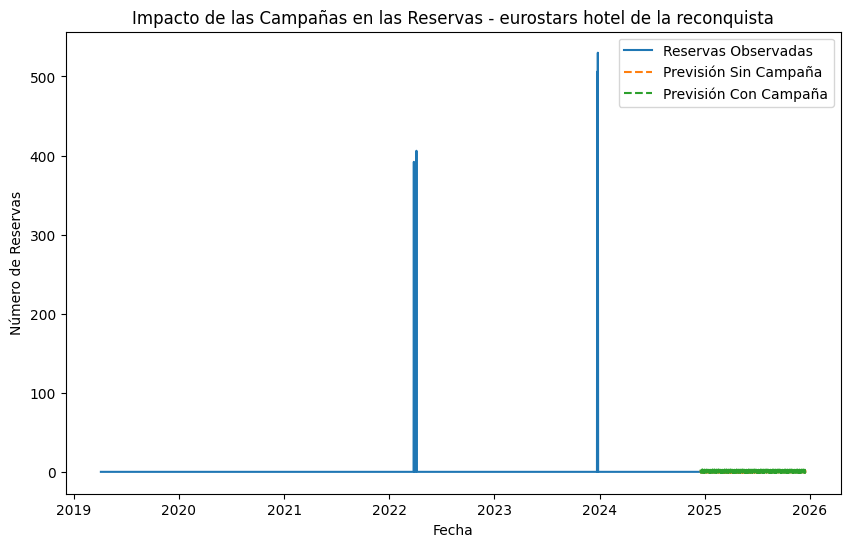

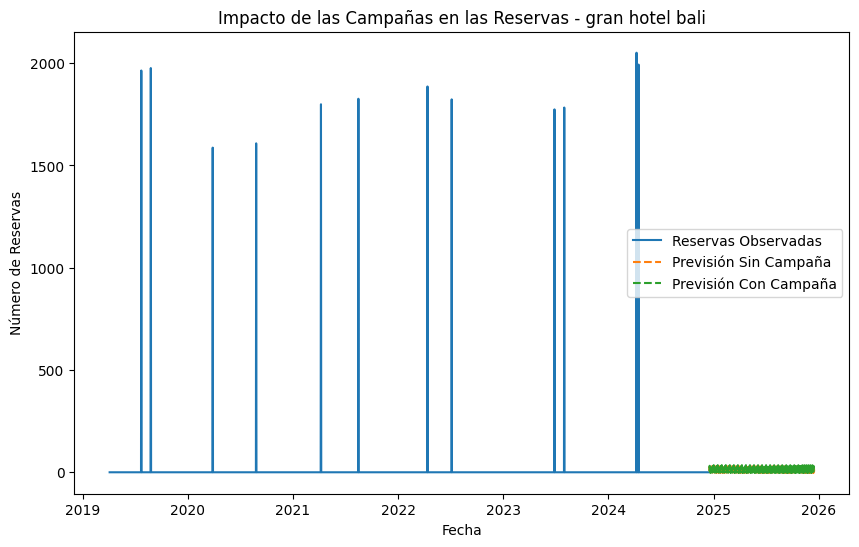

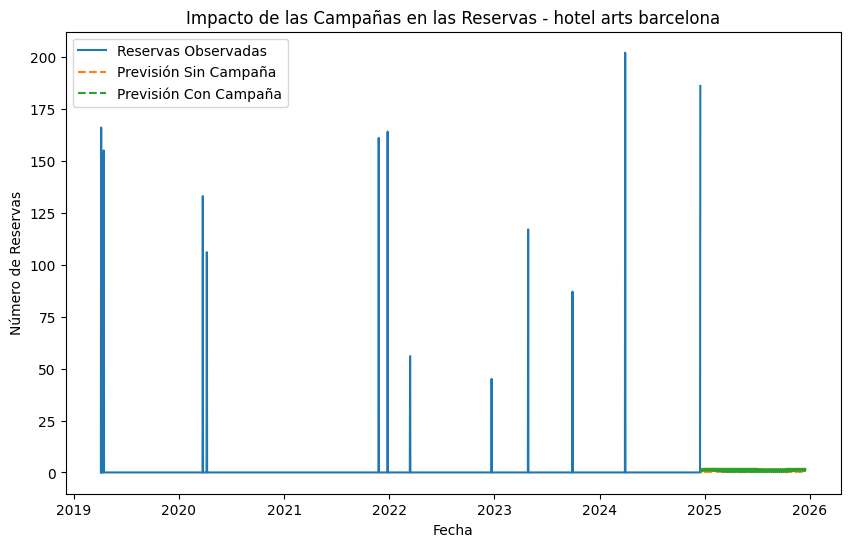

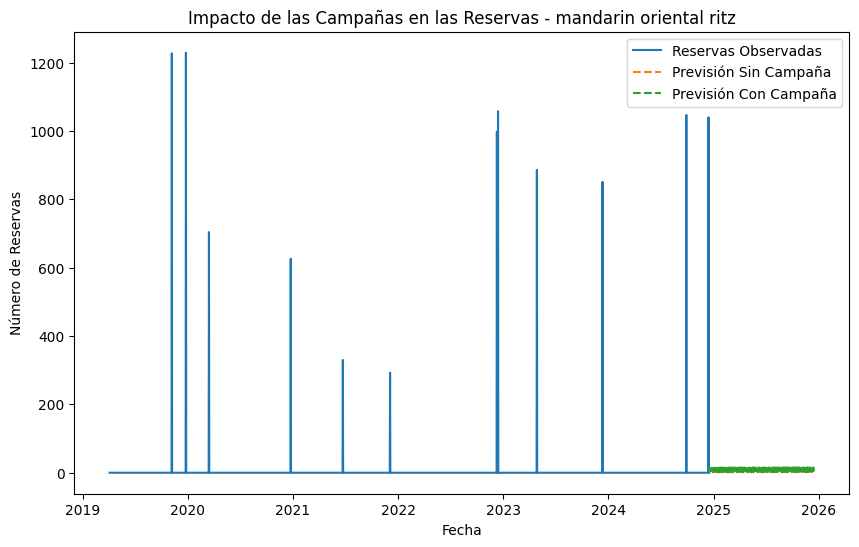

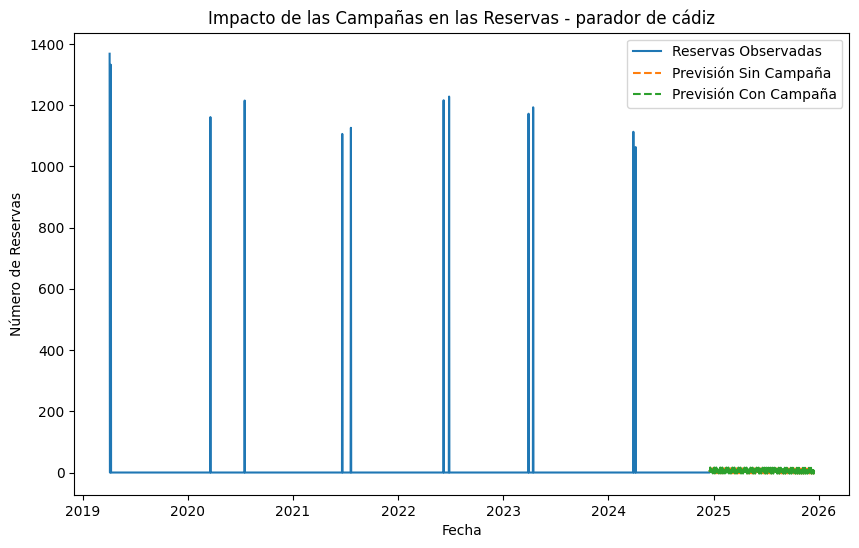

In [55]:
import matplotlib.pyplot as plt

for hotel in reservas_ts.columns:
    plt.figure(figsize=(10, 6))
    # Observadas
    plt.plot(reservas_ts.index, reservas_ts[hotel], label='Reservas Observadas')
    # Previsión sin campaña
    forecast_mean = sarima_results[hotel].get_forecast(steps=365).predicted_mean
    plt.plot(forecast_mean.index, forecast_mean, label='Previsión Sin Campaña', linestyle='--')
    # Previsión con campaña (ejemplo: +20%)
    reservas_con_campaña = forecast_mean * 1.2
    plt.plot(forecast_mean.index, reservas_con_campaña, label='Previsión Con Campaña', linestyle='--')
    plt.legend()
    plt.title(f'Impacto de las Campañas en las Reservas - {hotel}')
    plt.xlabel('Fecha')
    plt.ylabel('Número de Reservas')
    plt.show()

In [56]:
import pandas as pd

# Agrupar por hotel, año, mes y si hay campaña
reservas_periodo = df.groupby(['hotel', 'año', 'mes', 'tiene_campaña']).size().reset_index(name='reservas')

# Filtrar reservas con campaña
reservas_con_campaña = reservas_periodo[reservas_periodo['tiene_campaña'] == 1]

# Filtrar reservas sin campaña
reservas_sin_campaña = reservas_periodo[reservas_periodo['tiene_campaña'] == 0]


In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un conjunto de subgráficos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Graficar reservas con campaña por hotel
for hotel in reservas_con_campaña['hotel'].unique():
    data_con = reservas_con_campaña[reservas_con_campaña['hotel'] == hotel]
    data_sin = reservas_sin_campaña[reservas_sin_campaña['hotel'] == hotel]
    
    # Unir los datos de reservas con y sin campaña
    data = pd.merge(data_con, data_sin, on=['hotel', 'año', 'mes'], how='outer', suffixes=('_con', '_sin'))
    data.fillna(0, inplace=True)  # Reemplazar NaN por 0
    
    # Graficar las barras apiladas
    axes[0].barh(data['mes'], data['reservas_con'], label=f'{hotel} - Con Campaña')
    axes[0].barh(data['mes'], data['reservas_sin'], left=data['reservas_con'], label=f'{hotel} - Sin Campaña')

axes[0].set_title('Reservas por Mes y Hotel')
axes[0].set_xlabel('Número de Reservas')
axes[0].set_ylabel('Mes')
axes[0].legend()

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>